In [1]:
import os, pickle
import pandas as pd
import numpy as np
from tensorflow.keras import models, layers, initializers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

shuffle = True
random_state = True

In [2]:
input_ = {
    "model_id": "20231026000000",
    "start_time": "2023-09-01 00:00:00",
    "end_time": "2023-10-10 00:00:00",
    "model_type": 0
}

root = os.getcwd()
model_id = input_["model_id"]
model_path = os.path.join(root, "data", "train", model_id, "ng1_3")
os.makedirs(model_path, exist_ok = True)
        
model_detail = os.path.join(model_path, "model")
os.makedirs(model_detail, exist_ok = True)

In [3]:
dfs = []
for i in range(4):
    df = pd.read_excel("data/train/train_split.xlsx", sheet_name = f"model{i + 1}")
    print(f"model: {i + 1}, columns: {df.shape[1]}, length: {df.shape[0]}")
    dfs.append(df)

df.head(3)

model: 1, columns: 6, length: 1200
model: 2, columns: 7, length: 1200
model: 3, columns: 10, length: 1200
model: 4, columns: 20, length: 1200


,Y距離(7)\n距離(A0.左邊)_AV,Y距離(7)\n距離(A0.左邊)_DV,Y距離(7)\n距離(A0.左邊)_ER,Y距離(8)\n距離(A0.右邊)_AV,Y距離(8)\n距離(A0.右邊)_DV,Y距離(5)\n距離(A0.左邊)(A0.右邊)_AV,Y距離(5)\n距離(A0.左邊)(A0.右邊)_DV,Y距離(9)\n距離(A180.左邊)_AV,Y距離(9)\n距離(A180.左邊)_DV,Y距離(9)\n距離(A180.左邊)_ER,Y距離(10)\n距離(A180.右邊)_AV,Y距離(10)\n距離(A180.右邊)_DV,Y距離(10)\n距離(A180.右邊)_ER,Y距離(6)\n距離(A180.左邊)(A180.右邊)_AV,Y距離(6)\n距離(A180.左邊)(A180.右邊)_DV,Y距離(6)\n距離(A180.左邊)(A180.右邊)_ER,XY距離(1)\n距離_AV,XY距離(1)\n距離_DV,XY距離(1)\n距離_ER,target
0,100.011,0.011,0.001,99.991,-0.009,66.012,0.012,99.990,-0.010,0.0,100.010,0.010,0.0,66.008,0.008,0.000,240.301,0.001,0.000,1
1,100.000,0.000,0.000,99.999,-0.001,66.012,0.012,99.999,-0.001,0.0,99.995,-0.005,0.0,66.011,0.011,0.000,240.321,0.021,0.000,1
2,99.997,-0.003,0.000,100.001,0.001,66.002,0.002,99.996,-0.004,0.0,99.998,-0.002,0.0,65.992,-0.008,-0.008,240.242,-0.058,-0.008,0


In [4]:
total_model = {}
for i, df in enumerate(dfs, start = 1):
    print(f"model{i}".center(130, '_'))

    # split data
    X = df.drop("target", axis = 1)
    y = df["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, stratify = y, shuffle = shuffle)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.15, random_state = random_state, stratify = y_train, shuffle = shuffle)

    # save features    
    pickle.dump(X_train.columns, open(os.path.join(model_detail, f"features{i}.pkl"),  "wb"))

    # Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)    
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)
    
    # build model
    model = models.Sequential([
        layers.Dense(64, input_shape = (X.shape[1], ), kernel_initializer = initializers.he_normal()), # 使用He初始化
        layers.BatchNormalization(),
        layers.Activation("relu"),
        # layers.Dropout(0.1),
        layers.Dense(32, kernel_initializer = initializers.he_normal()), # 使用He初始化
        layers.BatchNormalization(),
        layers.Activation('relu'),
        # layers.Dropout(0.1),
        layers.Dense(3, kernel_initializer = initializers.glorot_normal()), # 使用Xavier初始化
        layers.Activation("softmax")
    ], name = f"model{i}")

    model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

    # train model
    early_stopping = callbacks.EarlyStopping(monitor = "val_loss", patience = 5)
    history = model.fit(X_train, y_train, epochs = 50, batch_size = 256, validation_data = (X_valid, y_valid), callbacks = [early_stopping])

    # save model
    pickle.dump(scaler, open(os.path.join(model_detail, f"scaler{i}.pkl"), "wb"))
    pickle.dump(model, open(os.path.join(model_detail, f"model{i}.pkl"),  "wb"))

    # save result
    y_train_pred = model.predict(X_train).argmax(axis = 1)
    y_valid_pred = model.predict(X_valid).argmax(axis = 1)
    y_test_pred = model.predict(X_test).argmax(axis = 1)

    total_model[i] = {
        "model": model,
        "training_loss": history.history['loss'],
        "validation_loss": history.history['val_loss'],
        "train":{
            "target": y_train.to_numpy(),
            "pred": y_train_pred
        },
        "valid":{
            "target": y_valid.to_numpy(),
            "pred": y_valid_pred
        },
        "test":{
            "target": y_test.to_numpy(),
            "pred": y_test_pred
        }
    }    

______________________________________________________________model1______________________________________________________________
Epoch 1/50
4/4 [==============================] - 1s 47ms/step - loss: 1.1060 - accuracy: 0.3799 - val_loss: 1.0745 - val_accuracy: 0.6458
Epoch 2/50
4/4 [==============================] - 0s 7ms/step - loss: 0.9005 - accuracy: 0.6091 - val_loss: 0.8859 - val_accuracy: 0.6806
Epoch 3/50
4/4 [==============================] - 0s 7ms/step - loss: 0.7605 - accuracy: 0.7083 - val_loss: 0.7533 - val_accuracy: 0.7500
Epoch 4/50
4/4 [==============================] - 0s 8ms/step - loss: 0.6540 - accuracy: 0.7745 - val_loss: 0.6681 - val_accuracy: 0.7708
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 0.5787 - accuracy: 0.8260 - val_loss: 0.6139 - val_accuracy: 0.7569
Epoch 6/50
4/4 [==============================] - 0s 8ms/step - loss: 0.5220 - accuracy: 0.8640 - val_loss: 0.5766 - val_accuracy: 0.7708
Epoch 7/50
4/4 [========================

In [5]:
# calculate model score
score = []
for (key, values) in total_model.items():
    f1_train = f1_score(values["train"]["target"], values["train"]["pred"], average = 'macro')
    f1_valid = f1_score(values["valid"]["target"], values["valid"]["pred"], average = 'macro')
    f1_test = f1_score(values["test"]["target"], values["test"]["pred"], average = 'macro')
    score.append([key, f1_train, f1_valid, f1_test])
score = pd.DataFrame(score, columns = ["model", "train", "valid", "test"]).round(4)
score.to_csv(f"{model_path}/f1_score.csv", index = False)
score

,model,train,valid,test
0,1,0.8603,0.8669,0.8680
1,2,0.9003,0.9153,0.8812
2,3,0.9199,0.9001,0.9317
3,4,0.8765,0.8215,0.8323


In [6]:
use_index = score["test"].nlargest(3).index[-1]
ng1_3_score1 = score.loc[use_index, "test"]
use_index, ng1_3_score1

(0, 0.868)

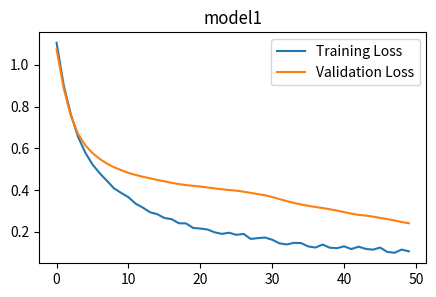

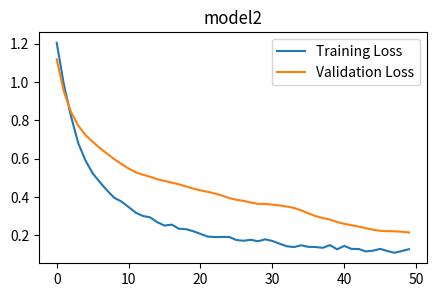

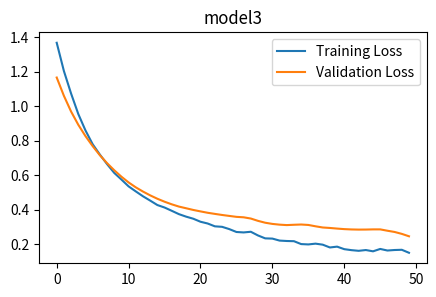

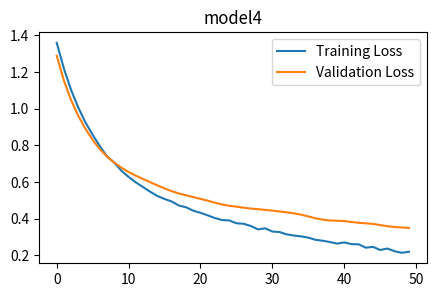

In [7]:
for i, (key, values) in enumerate(total_model.items()):
    plt.figure(figsize = (5, 3))
    plt.plot(values["training_loss"], label="Training Loss")
    plt.plot(values["validation_loss"], label="Validation Loss")
    plt.title(f"model{key}")
    plt.legend()
    plt.savefig(f"{model_path}/loss_curve{key}.png")

fig, ax = plt.subplots(1, 4, figsize = (20, 4))
for i, (key, values) in enumerate(total_model.items()):
    ax[i].plot(values["training_loss"], label="Training Loss")
    ax[i].plot(values["validation_loss"], label="Validation Loss")
    ax[i].set_title(f"model{key}")
    ax[i].legend()
fig.savefig(f"{model_path}/loss_curve.png")

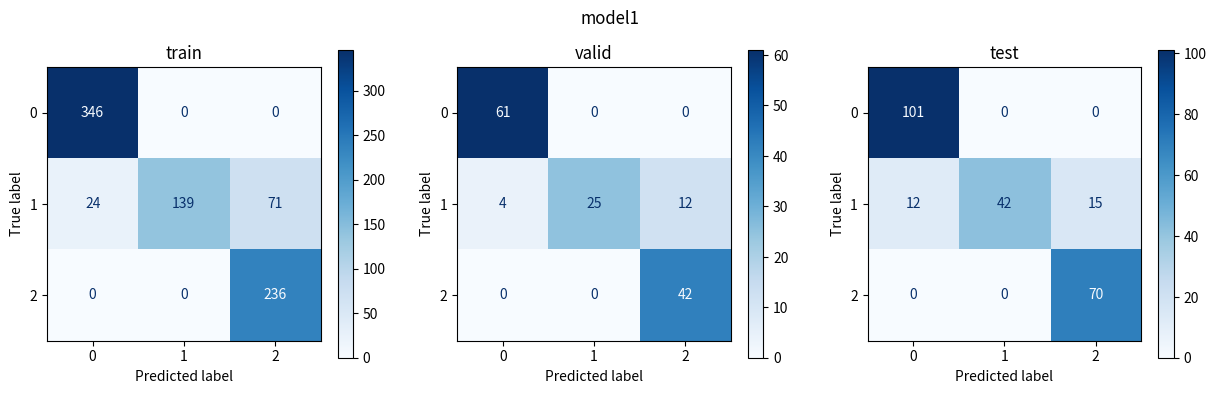

-------------------------train-------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       346
           1       1.00      0.59      0.75       234
           2       0.77      1.00      0.87       236

    accuracy                           0.88       816
   macro avg       0.90      0.86      0.86       816
weighted avg       0.91      0.88      0.87       816

-------------------------valid-------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        61
           1       1.00      0.61      0.76        41
           2       0.78      1.00      0.88        42

    accuracy                           0.89       144
   macro avg       0.91      0.87      0.87       144
weighted avg       0.91      0.89      0.88       144

--------------------------test-------------------------
              precision    recall  f1-score   support

           0   

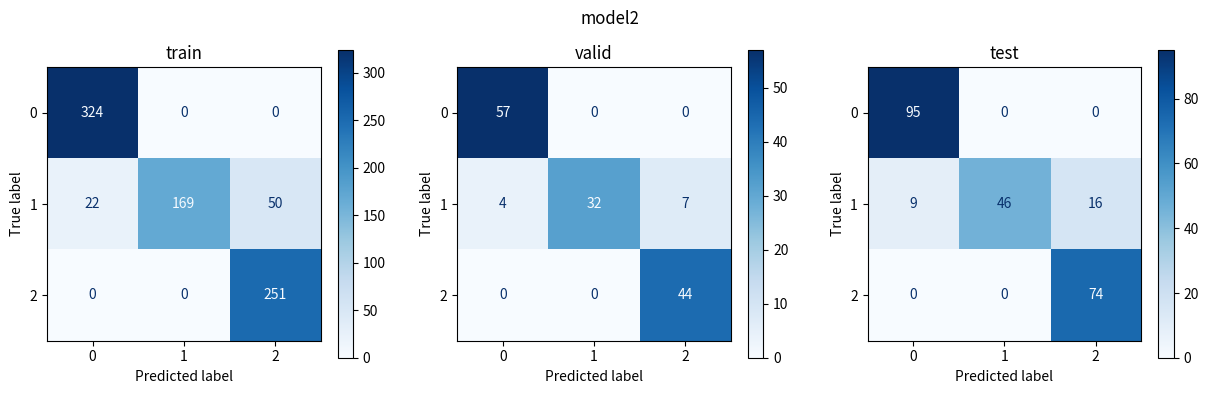

-------------------------train-------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       324
           1       1.00      0.70      0.82       241
           2       0.83      1.00      0.91       251

    accuracy                           0.91       816
   macro avg       0.92      0.90      0.90       816
weighted avg       0.92      0.91      0.91       816

-------------------------valid-------------------------
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        57
           1       1.00      0.74      0.85        43
           2       0.86      1.00      0.93        44

    accuracy                           0.92       144
   macro avg       0.93      0.91      0.92       144
weighted avg       0.93      0.92      0.92       144

--------------------------test-------------------------
              precision    recall  f1-score   support

           0   

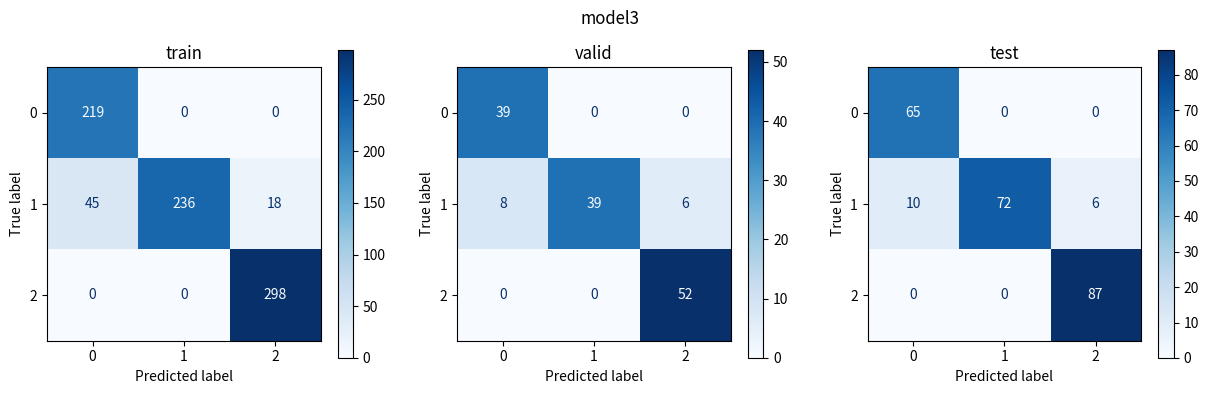

-------------------------train-------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       219
           1       1.00      0.79      0.88       299
           2       0.94      1.00      0.97       298

    accuracy                           0.92       816
   macro avg       0.92      0.93      0.92       816
weighted avg       0.93      0.92      0.92       816

-------------------------valid-------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        39
           1       1.00      0.74      0.85        53
           2       0.90      1.00      0.95        52

    accuracy                           0.90       144
   macro avg       0.91      0.91      0.90       144
weighted avg       0.92      0.90      0.90       144

--------------------------test-------------------------
              precision    recall  f1-score   support

           0   

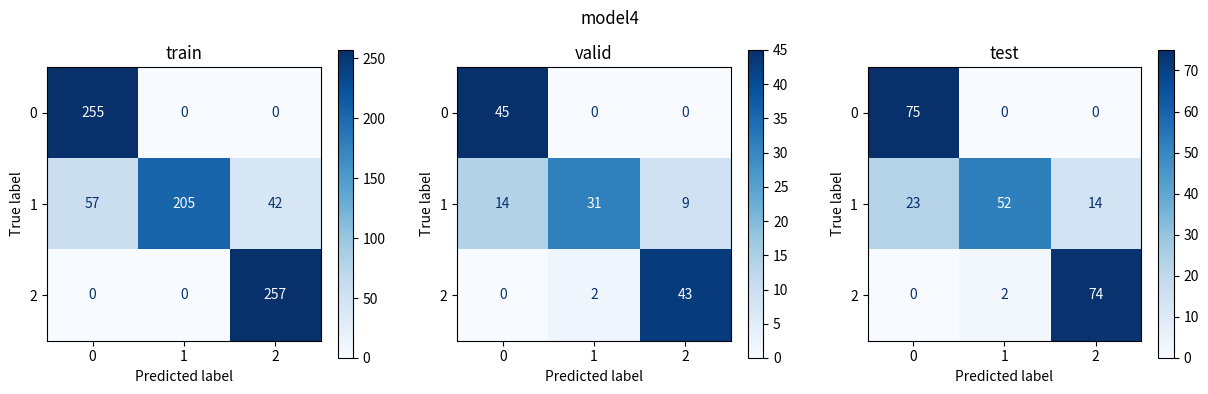

-------------------------train-------------------------
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       255
           1       1.00      0.67      0.81       304
           2       0.86      1.00      0.92       257

    accuracy                           0.88       816
   macro avg       0.89      0.89      0.88       816
weighted avg       0.90      0.88      0.87       816

-------------------------valid-------------------------
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        45
           1       0.94      0.57      0.71        54
           2       0.83      0.96      0.89        45

    accuracy                           0.83       144
   macro avg       0.84      0.84      0.82       144
weighted avg       0.85      0.83      0.81       144

--------------------------test-------------------------
              precision    recall  f1-score   support

           0   

In [8]:
for i, (key, values) in enumerate(total_model.items()):
    fig, ax = plt.subplots(1, 3, figsize = (15, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(values["train"]["target"], values["train"]["pred"]))#, display_labels = (set(y_train) | set(pred_trains[f"{name}_train"])))
    disp.plot(cmap = plt.cm.Blues, ax = ax[0])
    ax[0].set_title("train")

    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(values["valid"]["target"], values["valid"]["pred"]))#, display_labels = (set(y_test) | set(pred_tests[f"{name}_test"])))
    disp.plot(cmap = plt.cm.Blues, ax = ax[1])
    ax[1].set_title("valid")

    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(values["test"]["target"], values["test"]["pred"]))#, display_labels = (set(y_test) | set(pred_tests[f"{name}_test"])))
    disp.plot(cmap = plt.cm.Blues, ax = ax[2])
    ax[2].set_title("test")

    fig.suptitle(f"model{key}")
    plt.show()

    fig.savefig(f"{model_path}/confusion_matrix{i+1}.png")

    
    print(f"train".center(55, '-'))
    print(classification_report(values["train"]["target"], values["train"]["pred"]))
    print(f"valid".center(55, '-'))
    print(classification_report(values["valid"]["target"], values["valid"]["pred"]))
    print(f"test".center(55, '-'))
    print(classification_report(values["test"]["target"], values["test"]["pred"]))
    print("_" * 150)

In [9]:
for key, values in total_model.items():
    values["model"].summary()
    print("\n")

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 32)                0    